# Benchmarking numpy / scikit-image / scipy vs  clesperanto

In [1]:
import clesperanto as cle
import numpy as np
import time
import matplotlib.pyplot as plt

num_iterations = 10

# measure execution time of a given method
def benchmark(function, kwargs):
    times = []
    for i in range(0, num_iterations):
        start_time = time.time()
        function(**kwargs)
        delta_time = time.time() - start_time
        times = times + [delta_time]
        # print(delta_time)

    # return median of measurements to ignore warmup-effects
    return np.median(times)



def benchmark_size(method_np, method_cle, method_cle_alloc):
    times_ref = []
    times_cle = []
    times_cle_alloc = []
    sizes = []
    for size in [1, 2, 4, 8, 16, 32, 64]:

        input1 = np.zeros((1024, 1024, size))
        cl_input1 = cle.push(input1)
        cl_input2 = cle.create(cl_input1.shape)

        time_ref = benchmark(method_np, {"image":input1})
        time_cle = benchmark(method_cle, {"image":cl_input1, "output":cl_input2})
        time_cle_alloc = benchmark(method_cle_alloc, {"image":cl_input1})

        times_ref = times_ref + [time_ref]
        times_cle = times_cle + [time_cle]
        times_cle_alloc = times_cle_alloc + [time_cle_alloc]
        sizes = sizes + [size]

    plt.plot(sizes, times_ref,  'r--', sizes, times_cle, 'g--', sizes, times_cle_alloc, 'b--');
    plt.ylabel('Time / ms')
    plt.xlabel('Image size / MB')
    plt.legend(("ref", "cle", "cle+alloc"));
    plt.show()


    print("\nSizes (MB)        " + str(sizes))
    print("Times ref (s)       " + str(np.round(times_ref, 4)))
    print("Times cle (s)       " + str(np.round(times_cle, 4)))
    print("Times cle+alloc (s) " + str(np.round(times_cle_alloc, 4)))


## Thresholding

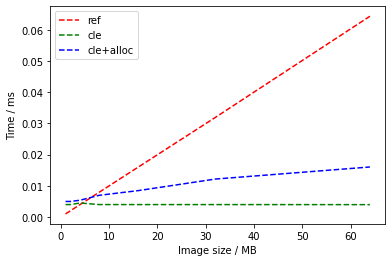


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.001  0.002  0.004  0.008  0.016  0.0319 0.0643]
Times cle (s)       [0.004  0.004  0.0045 0.004  0.004  0.004  0.004 ]
Times cle+alloc (s) [0.005  0.005  0.0054 0.007  0.0085 0.0122 0.016 ]


In [2]:
# RED: thresholding of a numpy array
def threshold_ref(image):
    thresholded = image > 100
    return thresholded

# GREEN: thresholding of a pre-existing opencl array (no push, pull or alloc)
def threshold_cle(image, output):
    cle.greater_constant(image, output, 100)

# BLUE: allocate result memory + thresholding 
def threshold_cle_alloc(image):
    thresholded = cle.create(image.shape)
    cle.greater_constant(image, thresholded, 100)

benchmark_size(threshold_ref, threshold_cle, threshold_cle_alloc)

## Gaussian blur radius 2

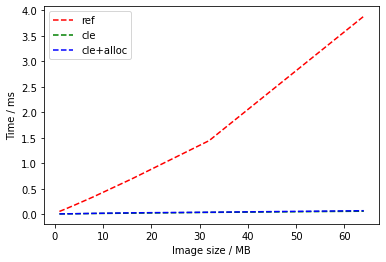


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.0588 0.0967 0.177  0.3436 0.6976 1.4471 3.8856]
Times cle (s)       [0.01   0.0115 0.0131 0.0177 0.025  0.0395 0.0629]
Times cle+alloc (s) [0.0105 0.012  0.014  0.0209 0.0315 0.0433 0.0729]


In [3]:
from skimage.filters import gaussian

radius = 2

def gaussian_blur_filter_ref(image):
    filtered = gaussian(image, sigma=radius)
    return filtered

def gaussian_blur_filter_cle(image, output):
    cle.gaussian_blur(image, output, radius, radius, radius)

def gaussian_blur_filter_cle_alloc(image):
    filtered = cle.create(image.shape)
    cle.gaussian_blur(image, filtered, radius, radius, radius)

benchmark_size(gaussian_blur_filter_ref, gaussian_blur_filter_cle, gaussian_blur_filter_cle_alloc)


## Gaussian blur radius 10

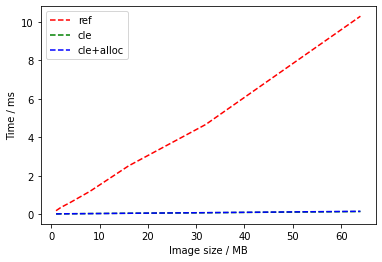


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [ 0.1795  0.35    0.6149  1.1837  2.5068  4.662  10.2835]
Times cle (s)       [0.013  0.0177 0.0219 0.0324 0.0461 0.0734 0.1366]
Times cle+alloc (s) [0.0129 0.019  0.0229 0.0283 0.0462 0.0788 0.1486]


In [4]:
radius = 10
benchmark_size(gaussian_blur_filter_ref, gaussian_blur_filter_cle, gaussian_blur_filter_cle_alloc)


## Binary erosion

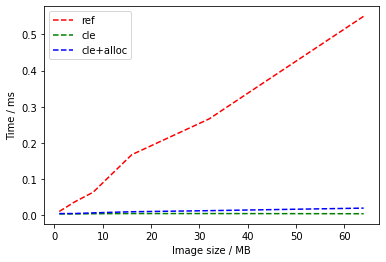


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.011  0.0189 0.0359 0.0639 0.1676 0.2663 0.55  ]
Times cle (s)       [0.004  0.004  0.004  0.0045 0.005  0.005  0.0045]
Times cle+alloc (s) [0.005  0.005  0.005  0.0069 0.01   0.013  0.02  ]


In [5]:

from skimage.morphology import binary_erosion


def binary_erosion_ref(image):
    filtered = binary_erosion(image)
    return filtered

def binary_erosion_cle(image, output):
    cle.erode_box(image, output)

def binary_erosion_cle_alloc(image):
    filtered = cle.create(image.shape)
    cle.erode_box(image, filtered)

benchmark_size(binary_erosion_ref, binary_erosion_cle, binary_erosion_cle_alloc)



## Mean filter radius=2

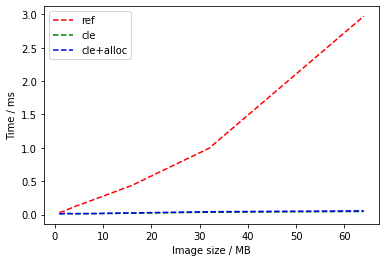


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.0319 0.0534 0.1157 0.2214 0.4373 0.9948 2.9721]
Times cle (s)       [0.0102 0.016  0.013  0.0149 0.0203 0.036  0.0468]
Times cle+alloc (s) [0.011  0.016  0.014  0.016  0.0254 0.0431 0.0563]


In [6]:

import scipy.ndimage.filters as spf


radius = 2
def mean_filter_ref(image):
    # todo: not sure if size is a radius or a diameter. Check documentation
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter.html#scipy.ndimage.uniform_filter
    filtered = spf.uniform_filter(image, size=radius)
    return filtered

def mean_filter_cle(image, output):
    cle.mean_box(image, output, radius, radius, radius)

def mean_filter_cle_alloc(image):
    filtered = cle.create(image.shape)
    cle.mean_box(image, filtered, radius, radius, radius)

benchmark_size(mean_filter_ref, mean_filter_cle, mean_filter_cle_alloc)
